<a href="https://colab.research.google.com/github/Jeze2/Prediction-of-product-sales/blob/main/sales_prediction_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [96]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
import missingno
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV

In [97]:
# from google.colab import drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
# Loading from URL for solution

fpath = "/content/drive/MyDrive/StudentFolders16wk20wk/CodingDojo (1)/02-MachineLearning/Week05/Data/sales_predictions_2023.csv"
df = pd.read_csv(fpath)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Cleaning Data

In [99]:
#View data types

In [100]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [101]:
#Checking for duplicates
df.duplicated().sum()

0

In [102]:
#Identify missing values.
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [103]:
#Find and fix any inconsistent categories of data
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [104]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'low fat':"Low Fat",'LF':'Low Fat', 'reg': 'Regular'})
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [105]:
#convert to the right type
df["Item_Weight"] = df["Item_Weight"].astype(float)
df["Item_Weight"].dtype

dtype('float64')

# Machine Learning

In [106]:
# Define features (X) and target (y).
X = df.drop(columns='Item_Outlet_Sales')
y = df['Item_Outlet_Sales']
## Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,NCG06,16.350,Low Fat,0.029565,Household,256.4646,OUT018,2009,Medium,Tier 3,Supermarket Type2
7510,FDV57,15.250,Regular,0.000000,Snack Foods,179.7660,OUT018,2009,Medium,Tier 3,Supermarket Type2
5828,FDM27,12.350,Regular,0.158716,Meat,157.2946,OUT049,1999,Medium,Tier 1,Supermarket Type1
5327,FDG24,7.975,Low Fat,0.014628,Baking Goods,82.3250,OUT035,2004,Small,Tier 2,Supermarket Type1
4810,FDD05,19.350,Low Fat,0.016645,Frozen Foods,120.9098,OUT045,2002,NaN,Tier 2,Supermarket Type1


In [107]:
# PREPROCESSING PIPELINE FOR NUMERIC DATA
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
num_pipe

Numeric Columns: Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [108]:
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
        'Outlet_Establishment_Year'],
       dtype='object'))

In [109]:
# PREPROCESSING PIPELINE FOR ORDINAL DATA
# Save list of number column names
ordinal_cols = ['Outlet_Location_Type', 'Outlet_Size']
# Ordered Category Lists
Outlet_Location_Type = ['Tier 1', 'Tier 2', 'Tier 3']
Outlet_Size = ['Small', 'Medium', 'High']
# Transformers
ord = OrdinalEncoder( categories = [Outlet_Location_Type, Outlet_Size])
freq_imputer = SimpleImputer(strategy='most_frequent')
# you might have 100 diff cat for ordinal so its getting out of range so good to scale
scaler2 = StandardScaler()
# Pipeline
ord_pipeline = make_pipeline(freq_imputer, ord, scaler2)
ord_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Tier 1', 'Tier 2', 'Tier 3'],
                                            ['Small', 'Medium', 'High']])),
                ('standardscaler', StandardScaler())])

In [110]:
# Tuple
ord_tuple = ('ordinal',ord_pipeline, ordinal_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Tier 1', 'Tier 2', 'Tier 3'],
                                             ['Small', 'Medium', 'High']])),
                 ('standardscaler', StandardScaler())]),
 ['Outlet_Location_Type', 'Outlet_Size'])

In [111]:
# PREPROCESSING PIPELINE FOR ONE-HOT-ENCODED DATA
# Save list of column names
ohe_cols = X_train.select_dtypes('object').drop(columns=ordinal_cols).columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "NA")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_pipe

OneHotEncoder Columns: Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Type'],
      dtype='object')


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='NA', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [112]:
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
ohe_tuple

('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
        'Outlet_Type'],
       dtype='object'))

In [113]:
# Instantiate the make column transformer
col_transformer = ColumnTransformer([num_tuple,
                                       ord_tuple,
                                       ohe_tuple],
                                       remainder='drop', verbose_feature_names_out=False)

In [114]:
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  Ord...
                                 ['Outlet_Location_Type', 'Outlet_Size']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [115]:
# Transform the X_train and the X_test
X_train_proc = col_transformer.transform(X_train)
X_test_proc = col_transformer.transform(X_test)

In [116]:
# Display the first (5) rows of the dataframe
display(X_train_proc.head())
# Check the shape
print(f'\nshape of processed data is: {X_train_proc.shape}')
# Check for remaining missing values
print(f'\nThere are {X_train_proc.isna().sum().sum()} missing values')
# Check the data types
print(f'\nThe datatypes are {X_train_proc.dtypes}')

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Size,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,Item_Identifier_DRB25,Item_Identifier_DRB48,Item_Identifier_DRC01,Item_Identifier_DRC12,Item_Identifier_DRC13,Item_Identifier_DRC25,Item_Identifier_DRC27,Item_Identifier_DRC36,Item_Identifier_DRC49,Item_Identifier_DRD01,Item_Identifier_DRD12,Item_Identifier_DRD13,Item_Identifier_DRD15,Item_Identifier_DRD24,Item_Identifier_DRD25,Item_Identifier_DRD27,Item_Identifier_DRD37,Item_Identifier_DRD49,Item_Identifier_DRD60,Item_Identifier_DRE01,Item_Identifier_DRE03,Item_Identifier_DRE12,Item_Identifier_DRE13,Item_Identifier_DRE15,Item_Identifier_DRE25,Item_Identifier_DRE27,Item_Identifier_DRE37,Item_Identifier_DRE48,Item_Identifier_DRE49,Item_Identifier_DRE60,Item_Identifier_DRF01,Item_Identifier_DRF03,Item_Identifier_DRF13,Item_Identifier_DRF15,Item_Identifier_DRF23,Item_Identifier_DRF25,Item_Identifier_DRF27,Item_Identifier_DRF36,...,Item_Identifier_NCY17,Item_Identifier_NCY18,Item_Identifier_NCY29,Item_Identifier_NCY30,Item_Identifier_NCY41,Item_Identifier_NCY42,Item_Identifier_NCY53,Item_Identifier_NCY54,Item_Identifier_NCZ05,Item_Identifier_NCZ06,Item_Identifier_NCZ17,Item_Identifier_NCZ18,Item_Identifier_NCZ29,Item_Identifier_NCZ30,Item_Identifier_NCZ41,Item_Identifier_NCZ42,Item_Identifier_NCZ53,Item_Identifier_NCZ54,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,0.827485,-0.712775,1.828109,1.327849,1.084948,0.287374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7510,0.566644,-1.291052,0.603369,1.327849,1.084948,0.287374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5828,-0.121028,1.813319,0.244541,0.136187,-1.384777,0.287374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5327,-1.158464,-1.004931,-0.952591,0.732018,-0.149914,-1.384048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4810,1.538870,-0.


shape of processed data is: (6392, 1588)

There are 0 missing values

The datatypes are Item_Weight                      float64
Item_Visibility                  float64
Item_MRP                         float64
Outlet_Establishment_Year        float64
Outlet_Location_Type             float64
                                  ...   
Outlet_Identifier_OUT049         float64
Outlet_Type_Grocery Store        float64
Outlet_Type_Supermarket Type1    float64
Outlet_Type_Supermarket Type2    float64
Outlet_Type_Supermarket Type3    float64
Length: 1588, dtype: object


## Linear Regression

In [117]:
#Define the model
lin_reg = LinearRegression()
lin_reg

LinearRegression()

In [118]:
# Fit the model on the training data
lin_reg.fit(X_train_proc, y_train)

LinearRegression()

In [119]:
# View the intercept determined during the fit step
lin_reg.intercept_.round(2)


453903318632371.25

In [120]:
# View the coefficents determined during the fit step
lin_reg.coef_.round(2)

array([ 1.08700000e+01, -3.13600000e+01, -6.98330000e+02, ...,
        1.24034921e+15,  4.66258694e+14,  8.09168247e+14])

In [121]:
# Get a list of the feature names after processing
feature_names = col_transformer.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP', ...,
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'], dtype=object)

In [122]:
coeffs = pd.Series(lin_reg.coef_.round(2), index = feature_names)
coeffs

Item_Weight                      1.087000e+01
Item_Visibility                 -3.136000e+01
Item_MRP                        -6.983300e+02
Outlet_Establishment_Year       -7.996388e+14
Outlet_Location_Type             1.110675e+14
                                     ...     
Outlet_Identifier_OUT049        -6.319255e+14
Outlet_Type_Grocery Store       -3.340353e+14
Outlet_Type_Supermarket Type1    1.240349e+15
Outlet_Type_Supermarket Type2    4.662587e+14
Outlet_Type_Supermarket Type3    8.091682e+14
Length: 1588, dtype: float64

In [123]:
# Get predictions for the training data
y_predictions_train = lin_reg.predict(X_train_proc)
# Get predictions for the testing data
y_predictions_test = lin_reg.predict(X_test_proc)

In [124]:
# Calculating MAE with numpy
train_MAE = np.mean(np.abs(y_predictions_train - y_train))
test_MAE = np.mean(np.abs(y_predictions_test - y_test))
print(f'Model Training MAE: {train_MAE:,.2f}')
print(f'Model Testing MAE: {test_MAE:,.2f}')

Model Training MAE: 737.07
Model Testing MAE: 500,343,919,146.89


In [125]:
# Calculating MSE with numpy
train_MSE = np.mean((y_predictions_train - y_train)**2)
test_MSE = np.mean((y_predictions_test - y_test)**2)
print(f'Model Training MSE: {train_MSE:,.2f}')
print(f'Model Testing MSE: {test_MSE:,.2f}')

Model Training MSE: 973,513.04
Model Testing MSE: 34,958,875,618,475,094,673,719,296.00


In [126]:
# Calculating RMSE with numpy
train_RMSE = np.sqrt(np.mean((y_predictions_train - y_train)**2))
test_RMSE = np.sqrt(np.mean((y_predictions_test - y_test)**2))
print(f'Model Training RMSE: {train_RMSE:,.2f}')
print(f'Model Testing RMSE: {test_RMSE:,.2f}')

Model Training RMSE: 986.67
Model Testing RMSE: 5,912,603,116,942.24


In [127]:
# Calculating R-Squared
train_r2 = np.corrcoef(y_train, y_predictions_train)[0][1]**2
test_r2 = np.corrcoef(y_test, y_predictions_test)[0][1]**2
print(f'Model Training R2: {train_r2:.2f}')
print(f'Model Testing R2: {test_r2:.2f}')

Model Training R2: 0.67
Model Testing R2: 0.00


- Based on these results, it appears that the model is overfitting the training data.

### Random Forest

In [128]:
# Add custom functions (from snippets if you have saved it)

def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

In [129]:
# Instantiate default random forest model
rf = RandomForestRegressor(random_state = 42)
# Model Pipeline
rf_pipe = make_pipeline(col_transformer, rf)

In [130]:
# Fit the model pipeline on the training data only
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='m...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Type'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [131]:
# Use custom function to evaluate default model
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 297.277
- MSE = 183,827.977
- RMSE = 428.752
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 772.829
- MSE = 1,240,389.519
- RMSE = 1,113.728
- R^2 = 0.550


Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?
- Since the R-squared value for the training data (0.938) is significantly higher than the R-squared value for the test data (0.550), we can conclude that the model is overfitting the training data.

Compare this model's performance to the linear regression model: which model has the best test scores?
- The Random forest has better scores

In [132]:
# Parameters for tuning
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
          'Outlet_Establishment_Year'],
         dtype='object')),
                                   ('ordinal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ordinalencoder',
                                                     Ord...
                                    ['Outlet_Location_Type', 'Outlet_Size']),
                       

In [133]:
# Define param grid with options to try
params = {'randomforestregressor__max_depth': [None,10,15,20],
          'randomforestregressor__n_estimators':[10,100,150,200],
          'randomforestregressor__min_samples_leaf':[2,3,4],
          'randomforestregressor__max_features':['sqrt','log2',None],
          'randomforestregressor__oob_score':[True,False],
          }

In [134]:
# Instantiate the gridsearch
gridsearch = GridSearchCV(rf_pipe, params, n_jobs=-1, cv = 3, verbose=1)
# Fit the gridsearch on training data
gridsearch.fit(X_train, y_train)


Fitting 3 folds for each of 288 candidates, totalling 864 fits


KeyboardInterrupt: ignored

In [ ]:
# Obtain best parameters
gridsearch.best_params_

In [ ]:
# Define and refit best model
best_rf = gridsearch.best_estimator_
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

Compare your tuned model to your default Random Forest: did the performance improve?
- It improves the results in training data

## Evaluation

- I would recommend Random forest because it gives you the best results

- In this case, the R-squared value for the training data is 0.938, which means that the model can explain approximately 93.8% of the variation in the training data. This indicates that the model fits the training data quite well and is able to capture the patterns and relationships present in that data.

- In this case, the MAE for the training data is 297.277, which means that, on average, the model's predictions deviate from the actual values by approximately 297.277 units. This indicates the average absolute difference between the predicted and actual values in the training data.
For the test data, the MAE is 772.829, suggesting that, on average, the model's predictions for the unseen data deviate from the actual values by around 772.829 units.

- I selected the Mean Absolute Error (MAE) as another regression metric to explain the model's performance to your stakeholder because it provides a straightforward and intuitive measure of the average prediction error.

- When comparing the R-squared values, we observe that the training R-squared (0.938) is significantly higher than the test R-squared (0.550). This discrepancy indicates that the model is performing much better on the training data than on the unseen test data. The relatively lower test R-squared suggests that the model is struggling to generalize and make accurate predictions for new data. We can conclude that the model is likely overfitting the training data.

## Deployment

### Overview

- The project involves developing a regression model to predict a target variable based on a set of independent variables. Regression models are used to analyze the relationship between variables and make predictions about numeric outcomes.
- The main objective of the project is to create a regression model that accurately predicts the target variable. The model aims to understand the patterns and relationships in the data, allowing it to make reliable predictions on unseen or new data.
- To assess the model's performance, various regression metrics are utilized. These metrics include Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared. These metrics provide insights into the accuracy, precision, and generalization capabilities of the model.

## EDA FUNCTIONS

In [138]:
"""UNIVARIATE PLOTTING FUNCTIONS FOR EDA"""
# Add the print statements to the function
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


# TO DO: add the new print statements from explore_categorical
def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes


In [140]:
"""MULTIVARIATE PLOTTING FUNCTIONS VS. NUMERIC TARGET"""

def plot_categorical_vs_target(df, x, y='rating',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  """Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax


def plot_numeric_vs_target(df, x, y='rating',
                           figsize=(6,4),
                           ):
  """Plots a seaborn regplot with Pearson's correlation (r) added
  to the title.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]

  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)

  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  # Make sure the plot is shown before the print statement
  plt.show()

  return fig, ax

### Visualizations

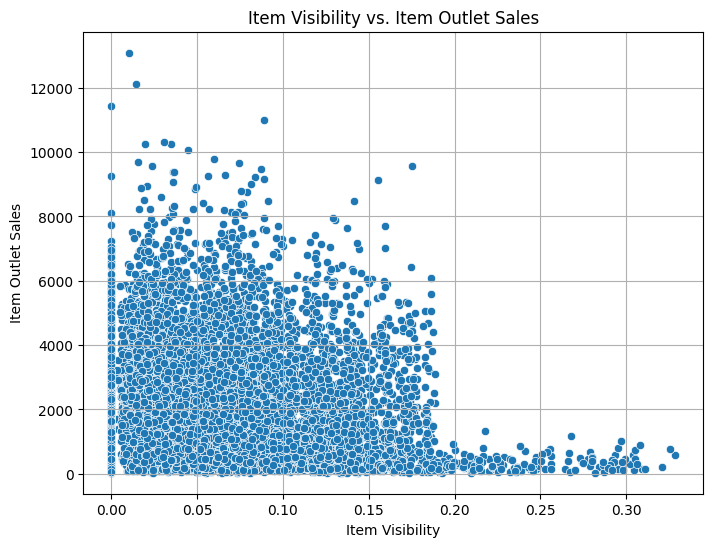

In [148]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Item_Visibility', y='Item_Outlet_Sales')
plt.xlabel('Item Visibility')
plt.ylabel('Item Outlet Sales')
plt.title('Item Visibility vs. Item Outlet Sales')
plt.grid(True)
plt.show()

- The scatter plot illustrates the relationship between item visibility and item outlet sales. We can observe the dispersion of data points, representing different products. By analyzing the scatter plot, we can infer whether there is any correlation between the visibility of products and their corresponding sales.

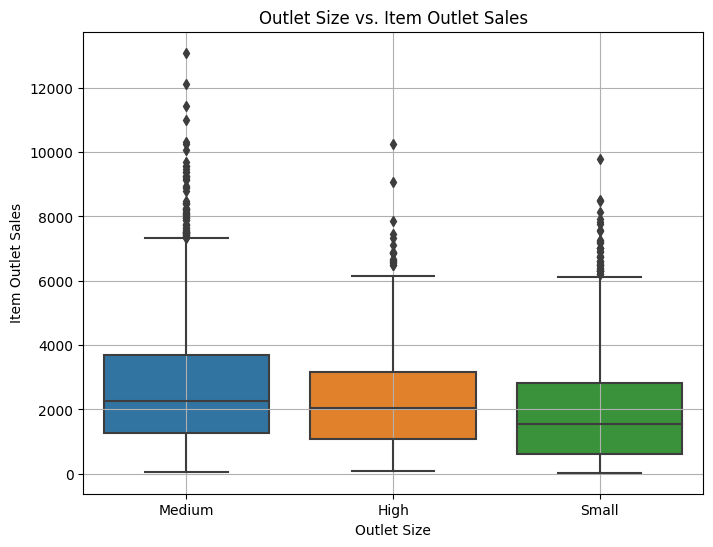

In [149]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Outlet_Size', y='Item_Outlet_Sales')
plt.xlabel('Outlet Size')
plt.ylabel('Item Outlet Sales')
plt.title('Outlet Size vs. Item Outlet Sales')
plt.grid(True)
plt.show()

- The box plot showcases the distribution of item outlet sales based on different outlet sizes. It allows us to compare the sales performance across different outlet sizes, whether small, medium, or large. By examining the box plot, we can identify any variations in sales and potential differences in consumer behavior based on the size of the outlet.

### Model Summary

- The model is a regression model, which analyzes the relationship between independent variables and a dependent variable to make predictions.
- The model has been trained using a dataset consisting of independent variables and corresponding target variable values.
- The goal of the model is to accurately predict the target variable based on the provided independent variables.

### Evaluation Metrics

- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- R-squared (R^2):
 - By analyzing these evaluation metrics, stakeholders can gain insights into the model's predictive accuracy, its ability to generalize to unseen data, and potential areas for improvement or adjustments in the model.

### Final recommendations

- Address Overfitting: The model appears to be overfitting the training data, as indicated by the significantly higher performance on the training set compared to the test set.
- Gather More Diverse Data: Collecting additional diverse and representative data can help improve the model's performance and generalization capabilities.
- Model Complexity: Examine the complexity of the current model. If the model is too complex, it may be prone to overfitting.
- Continuous Evaluation and Refinement: The model should be continuously evaluated and refined as new data becomes available. Monitor its performance on an ongoing basis, re-evaluate the metrics, and make necessary adjustments or enhancements to ensure its effectiveness.
